# 1. Introduction

# 2. Setup and Imports

In [48]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd

import cv2
from tqdm import tqdm
from PIL import Image, ImageOps
from brisque.brisque import BRISQUE

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
TARGET_SIZE = (448, 448)

# 3. Data Loading

In this section, we load all images from the FGSCM-52 dataset, storing them in arrays for further processing and analysis.

In [8]:
# Path to your dataset root (update as needed)
DATA_DIR = './data/'

# Initialize lists
X = []
y = []
paths = []

# Loop through class folders
labels = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Found {len(labels)} classes:")

for class_name in labels:
    class_path = os.path.join(DATA_DIR, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
    for img_file in tqdm(img_files, desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path).convert('RGB')
            X.append(img)
            y.append(class_name)
            paths.append(img_path)
        except Exception as e:
            print(f"Could not load {img_path}: {e}")

print(f"\nLoaded {len(X)} images.")

Found 52 classes:


Loading 017.Lzumo-class_helicopter_destroyer: 100%|██████████| 101/101 [00:00<00:00, 475.36it/s]
Loading 018.Whitby_Island-class_dock_landing_ship: 100%|██████████| 278/278 [00:00<00:00, 665.95it/s]
Loading 038.Atago-class_destroyer: 100%|██████████| 18/18 [00:00<00:00, 805.54it/s]
Loading 039.Mistral-class_amphibious_assault_ship: 100%|██████████| 5/5 [00:00<?, ?it/s]
Loading 040.Juan_Carlos_I_Strategic_Projection_Ship: 100%|██████████| 12/12 [00:00<00:00, 358.40it/s]
Loading 045.Ford-class aircraft carriers: 100%|██████████| 42/42 [00:00<00:00, 1315.27it/s]
Loading 046.Whidbey island-class dock landing ship: 100%|██████████| 611/611 [00:00<00:00, 2657.05it/s]
Loading 051.Asahi-class destroyer: 100%|██████████| 22/22 [00:00<?, ?it/s]
Loading 052.America-class_amphibious_assault_ship: 100%|██████████| 58/58 [00:00<00:00, 1769.16it/s]


Loaded 9562 images.


In [9]:
# Print all unique labels and their distribution
label_counts = pd.Series(y).value_counts()
print("\nLabel distribution:")
print(label_counts)


Label distribution:
029.Towing_vessel                              778
030.Civil_yacht                                777
046.Whidbey island-class dock landing ship     611
008.Ticonderoga-class_cruiser                  607
009.Arleigh_Burke-class_destroyer              580
001.Nimitz-class_aircraft_carrier              553
028.Container_ship                             455
014.Wasp-class_assault_ship                    453
019.San_Antonio-class_transport_dock           419
026.Cargo_ship                                 378
049.Tarawa Amphibious Assault Ship             371
031.Medical_ship                               322
018.Whitby_Island-class_dock_landing_ship      278
048.Oliver Hazard Perry class frigate          260
032.Sand_carrier                               226
021.Independence-class_combat_ship             210
003.Midway-class_aircraft_carrier              208
025.Megayacht                                  186
020.Freedom-class_combat_ship                  177
013.Type_4

In [10]:
superclass_map = {
    # Aircraft carriers
    '001.Nimitz-class_aircraft_carrier': 'Carrier',
    '002.KittyHawk-class_aircraft_carrier': 'Carrier',
    '003.Midway-class_aircraft_carrier': 'Carrier',
    '004.Kuznetsov-class_aircraft_carrier': 'Carrier',
    '005.Charles_de_Gaulle_aricraft_carrier': 'Carrier',
    '006.INS_Virrat_aircraft_carrier': 'Carrier',
    '007.INS_Vikramaditya_aircraft_carrier': 'Carrier',
    '034.Garibaldi_aircraft_carrier': 'Carrier',
    '045.Ford-class aircraft carriers': 'Carrier',
    
    # Destroyers
    '009.Arleigh_Burke-class_destroyer': 'Destroyer',
    '010.Akizuki-class_destroyer': 'Destroyer',
    '011.Asagiri-class_destroyer': 'Destroyer',
    '012.Kidd-class_destroyer': 'Destroyer',
    '013.Type_45_destroyer': 'Destroyer',
    '021.Independence-class_combat_ship': 'Destroyer',
    '020.Freedom-class_combat_ship': 'Destroyer',
    '027.Murasame-class_destroyer': 'Destroyer',
    '036.Kongo-class_destroyer': 'Destroyer',
    '037.Horizon-class_destroyer': 'Destroyer',
    '044.Hatsuyuki Class Destroyer': 'Destroyer',
    '047.Hobart Class Destroyer': 'Destroyer',
    '050.Sovremenny-class destroyer': 'Destroyer',
    '051.Asahi-class destroyer': 'Destroyer',
    '035.Zumwalt-class_destroyer': 'Destroyer',
    '017.Lzumo-class_helicopter_destroyer': 'Destroyer',
    '016.Hyuga-class_helicopter_destroyer': 'Destroyer',
    '038.Atago-class_destroyer': 'Destroyer',
    
    # Frigates
    '024.Abukuma-class_frigate': 'Frigate',
    '041.Maestrale-class_frigate': 'Frigate',
    '043.Aquitaine-class frigate': 'Frigate',
    '048.Oliver Hazard Perry class frigate': 'Frigate',
    
    # Cruisers
    '008.Ticonderoga-class_cruiser': 'Cruiser',
    
    # Amphibious/Assault/Dock Landing
    '014.Wasp-class_assault_ship': 'Amphibious',
    '039.Mistral-class_amphibious_assault_ship': 'Amphibious',
    '049.Tarawa Amphibious Assault Ship': 'Amphibious',
    '018.Whitby_Island-class_dock_landing_ship': 'Amphibious',
    '046.Whidbey island-class dock landing ship': 'Amphibious',
    '042.San_Giorgio-class_transport_dock': 'Amphibious',
    '019.San_Antonio-class_transport_dock': 'Amphibious',
    '015.Osumi-class_landing_ship': 'Amphibious',
    '052.America-class_amphibious_assault_ship': 'Amphibious',
    '040.Juan_Carlos_I_Strategic_Projection_Ship': 'Amphibious',
    
    # Support/Medical
    '022.Sacramento-class_support_ship': 'Support',
    '031.Medical_ship': 'Support',
    '023.Crane_ship': 'Support',
    
    # Civilian & Commercial
    '025.Megayacht': 'Civil',
    '030.Civil_yacht': 'Civil',
    '028.Container_ship': 'Civil',
    '026.Cargo_ship': 'Civil',
    '032.Sand_carrier': 'Civil',
    '033.Tank_ship': 'Civil',
    '029.Towing_vessel': 'Civil',
    
    # Others / ambiguous (fallback)
}

# Fill unmapped labels with their fine-grained class if not covered above
unique_labels = set(y)
for lbl in unique_labels:
    if lbl not in superclass_map:
        print(f"Warning: No superclass mapping for label '{lbl}'. Using 'Other'.")
        superclass_map[lbl] = 'Other'

# Create new label list for superclasses
super_y = [superclass_map.get(lbl, 'Other') for lbl in y]

# Print new superclass distribution
superclass_counts = pd.Series(super_y).value_counts()
print("Superclass distribution:")
print(superclass_counts)

Superclass distribution:
Civil         2959
Amphibious    2329
Destroyer     1754
Carrier        981
Cruiser        607
Support        514
Frigate        418
Name: count, dtype: int64


# 4. Image Preprocessing: Resizing and Padding

In [11]:
def resize_and_pad(img, target_size=(448, 448)):
    iw, ih = img.size
    tw, th = target_size

    # Scale image so the largest side matches the target size (no cropping)
    scale = min(tw / iw, th / ih)
    new_w, new_h = int(iw * scale), int(ih * scale)
    img_resized = img.resize((new_w, new_h), Image.LANCZOS)
    
    # Compute padding needed on each side
    pad_w = tw - new_w
    pad_h = th - new_h
    
    # Randomly distribute padding
    left = random.randint(0, pad_w)
    right = pad_w - left
    top = random.randint(0, pad_h)
    bottom = pad_h - top
    
    padding = (left, top, right, bottom)
    img_padded = ImageOps.expand(img_resized, padding, fill=(0, 0, 0))
    return img_padded

In [12]:
# Process all images and save new images and superclasses
processed_imgs = []
processed_labels = []

for img, superclass in zip(X, super_y):
    img_proc = resize_and_pad(img, TARGET_SIZE)
    processed_imgs.append(img_proc)
    processed_labels.append(superclass)

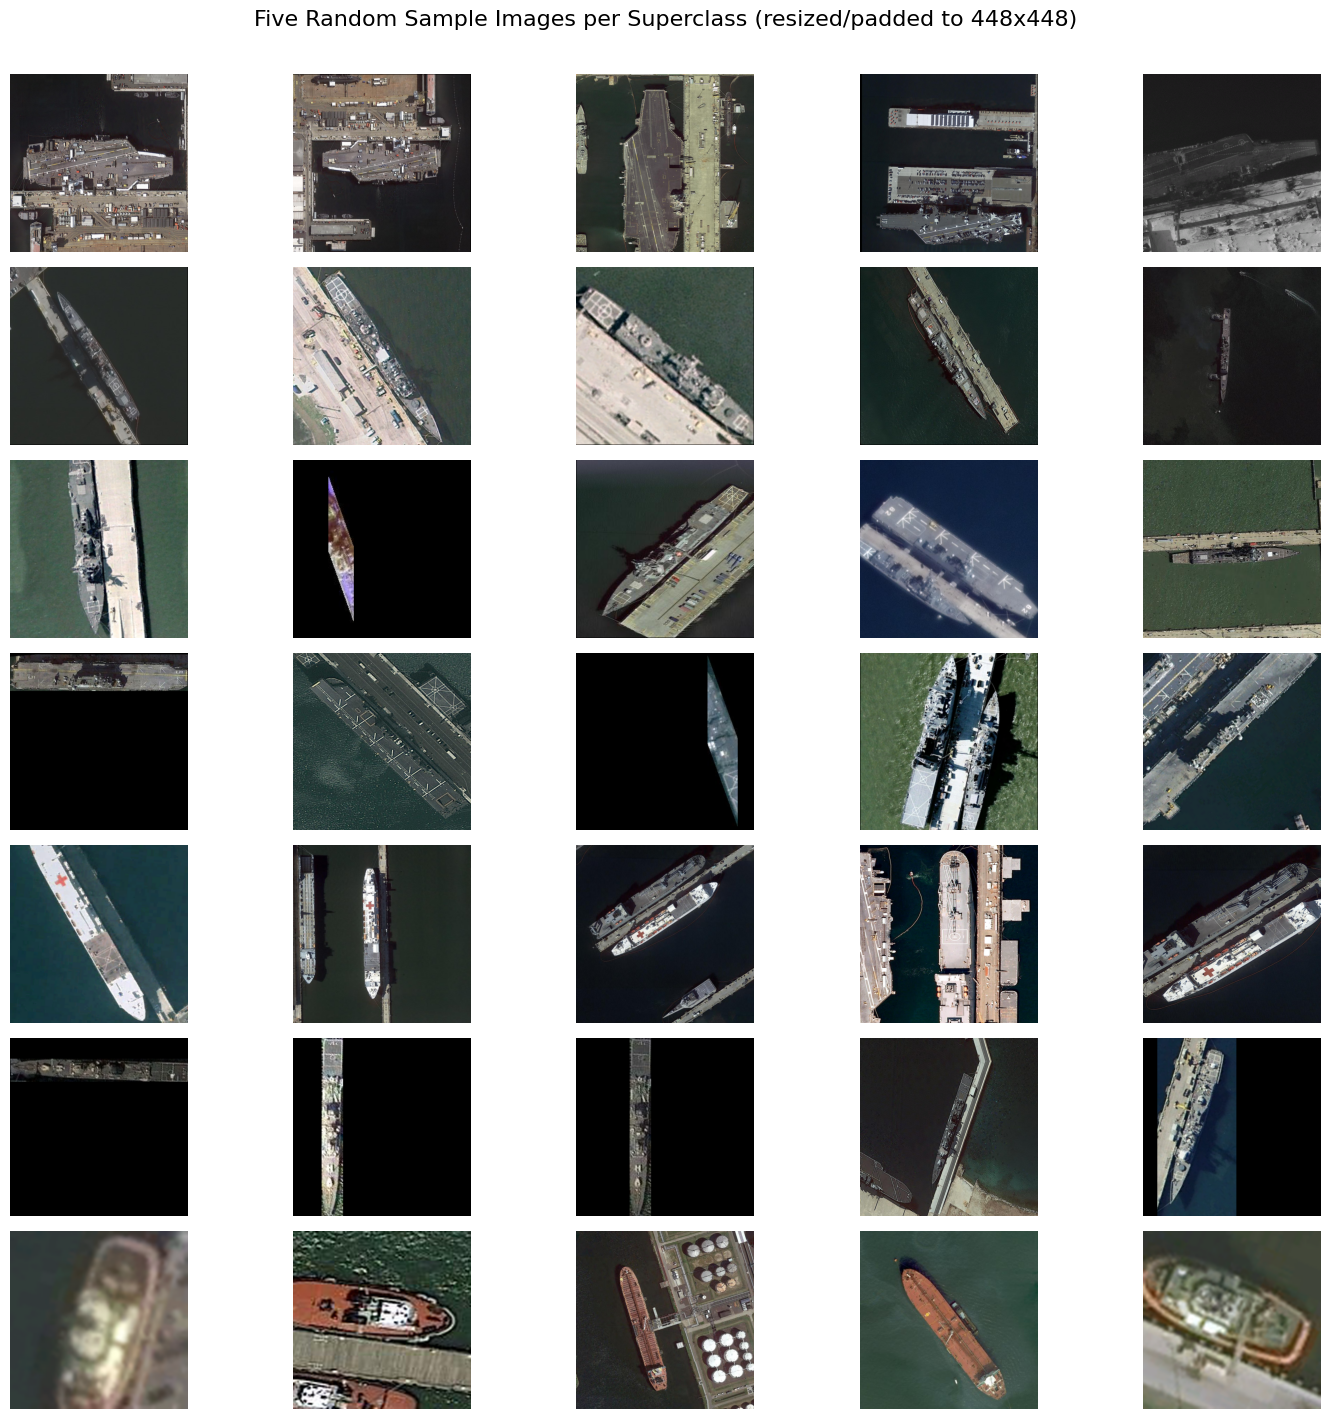

In [13]:
# Group images by superclass
images_by_class = defaultdict(list)
for img, label in zip(processed_imgs, processed_labels):
    images_by_class[label].append(img)

# Randomly sample 5 images per superclass
samples_by_class = {}
for label, imgs in images_by_class.items():
    n_samples = min(5, len(imgs))
    samples_by_class[label] = random.sample(imgs, n_samples)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 2 * len(samples_by_class)))
for row, (label, imgs) in enumerate(samples_by_class.items()):
    for col, img in enumerate(imgs):
        plt.subplot(len(samples_by_class), 5, row * 5 + col + 1)
        plt.imshow(img)
        plt.axis('off')
        if col == 0:
            plt.ylabel(label, fontsize=12)
plt.suptitle("Five Random Sample Images per Superclass (resized/padded to 448x448)", y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# Check all processed images have the correct size
correct = True
for idx, img in enumerate(processed_imgs):
    if img.size != TARGET_SIZE:
        print(f"Image at index {idx} has size {img.size}, expected {TARGET_SIZE}")
        correct = False

if correct:
    print(f"All images are {TARGET_SIZE} as expected!")
else:
    print("Some images do not have the correct size.")

All images are (448, 448) as expected!


# 5. Computing Image Quality: BRISQUE Scores

In [36]:
# Create BRISQUE object
brisque_model = BRISQUE(url=False)

# Compute BRISQUE scores for all images
brisque_scores = []
for img in tqdm(processed_imgs, desc="Computing BRISQUE scores"):
    img_arr = np.asarray(img)
    score = brisque_model.score(img=img_arr)
    score = max(0, min(100, score))
    brisque_scores.append(score)

# 1. Build a metadata DataFrame with paths, labels, and BRISQUE scores
df = pd.DataFrame({
    'img_path': paths,           # List of image file paths, e.g. "./FGSCM-52/Carrier/00123.jpg"
    'label': processed_labels,   # Superclass label for each image
    'brisque': brisque_scores    # Calculated BRISQUE score
})

# 2. Save metadata DataFrame (no image objects!)
df.to_csv('fgscm52_metadata.csv', index=False)
print("Saved metadata to fgscm52_metadata.csv")

brisque_scores = np.array(df['brisque'].tolist())
print(f"BRISQUE scores shape: {brisque_scores.shape}")

Computing BRISQUE scores: 100%|██████████| 9562/9562 [29:57<00:00,  5.32it/s]


Saved metadata to fgscm52_metadata.csv
BRISQUE scores shape: (9562,)


In [39]:
# Load CSV
df = pd.read_csv('fgscm52_metadata.csv')

# Create a mapping from path to BRISQUE score
path_to_brisque = dict(zip(df['img_path'], df['brisque']))

brisque_scores = np.array([path_to_brisque[p] for p in paths])

# print shape of brisque_scores
print(f"BRISQUE scores shape: {brisque_scores.shape}")

BRISQUE scores shape: (9562,)


# 6. Exploratory Data Analysis (EDA) of Image Quality (BRISQUE Scores)

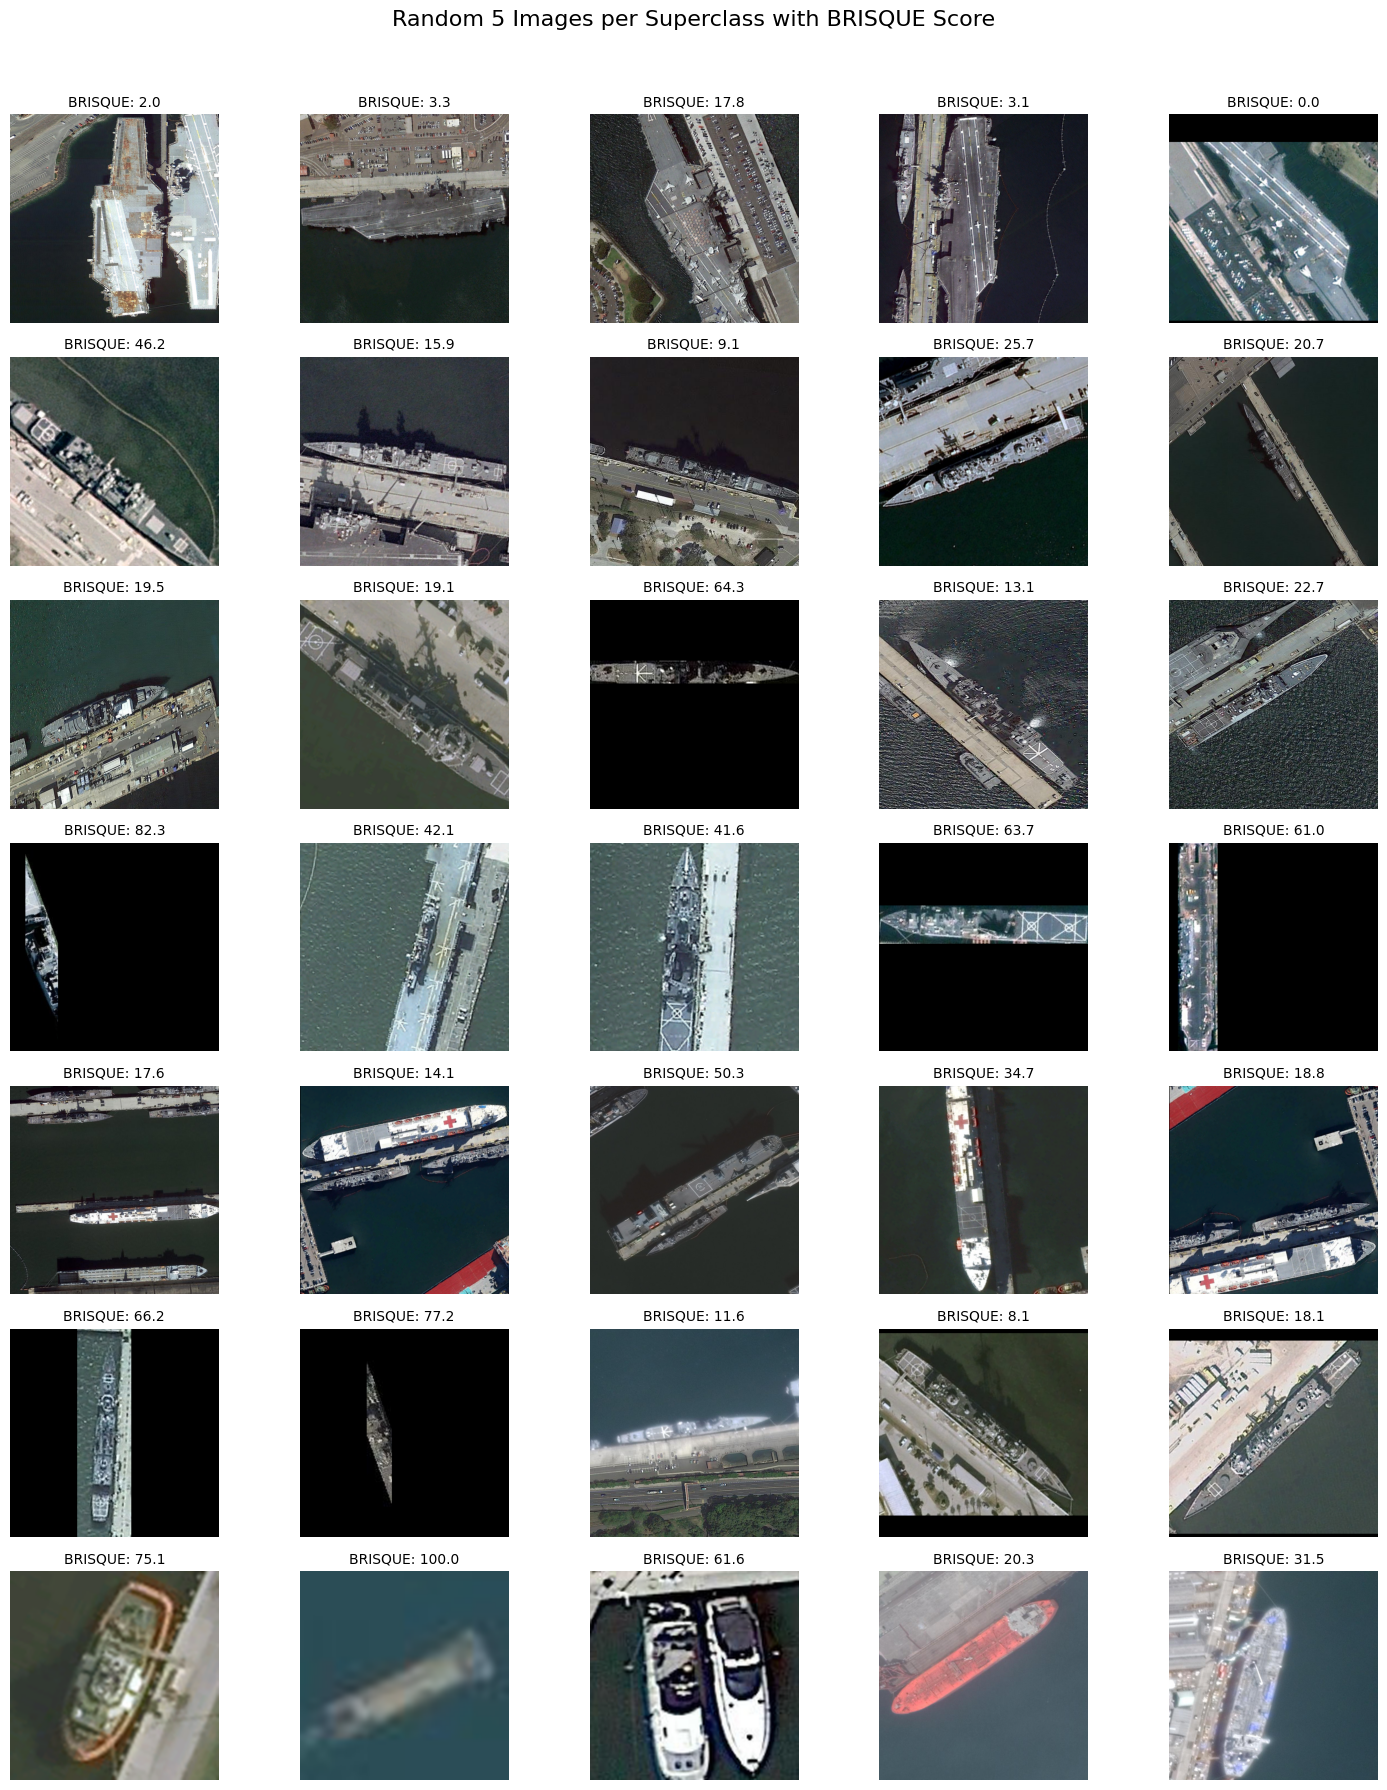

In [45]:
# Create a mapping from path to index in processed_imgs
path_to_idx = {p: i for i, p in enumerate(paths)}

superclasses = df['label'].unique()
plt.figure(figsize=(15, 2.5 * len(superclasses)))
plot_idx = 1

for superclass in superclasses:
    subset = df[df['label'] == superclass]
    if len(subset) == 0:
        continue
    sample_rows = subset.sample(min(5, len(subset)))
    for i, row in enumerate(sample_rows.itertuples()):
        idx = path_to_idx[row.img_path]
        img = processed_imgs[idx]
        plt.subplot(len(superclasses), 5, plot_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"BRISQUE: {row.brisque:.1f}", fontsize=10)
        if i == 0:
            plt.ylabel(superclass, fontsize=12)
        plot_idx += 1

plt.suptitle("Random 5 Images per Superclass with BRISQUE Score", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

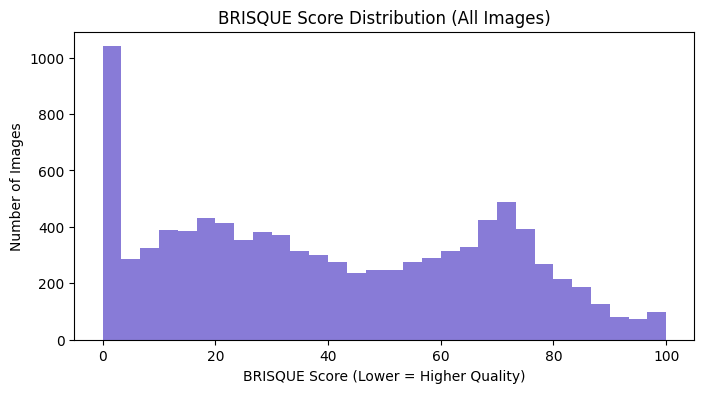

In [46]:
plt.figure(figsize=(8,4))
plt.hist(df['brisque'], bins=30, color='slateblue', alpha=0.8)
plt.title("BRISQUE Score Distribution (All Images)")
plt.xlabel("BRISQUE Score (Lower = Higher Quality)")
plt.ylabel("Number of Images")
plt.show()

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='brisque', data=df, palette="Set3")
plt.xticks(rotation=45, ha='right')
plt.title("BRISQUE Score by Superclass")
plt.xlabel("Superclass")
plt.ylabel("BRISQUE Score")
plt.tight_layout()
plt.show()

In [50]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='label', y='brisque', data=df, palette="Pastel1", cut=0)
plt.xticks(rotation=45, ha='right')
plt.title("BRISQUE Score by Superclass (Violin Plot)")
plt.xlabel("Superclass")
plt.ylabel("BRISQUE Score")
plt.tight_layout()
plt.show()

In [51]:
class_stats = df.groupby('label')['brisque'].describe()[['count','mean','std','min','25%','50%','75%','max']]
print(class_stats)

             count       mean        std       min        25%        50%  \
label                                                                      
Amphibious  2329.0  45.692542  29.114163  0.000000  19.034965  53.404532   
Carrier      981.0  18.628814  16.369859  0.000000   6.384109  16.428693   
Civil       2959.0  53.472964  26.460793  0.000000  32.749116  60.167378   
Cruiser      607.0  27.608668  19.301163  0.000000  11.705575  26.332783   
Destroyer   1754.0  31.795852  25.217176  0.000000  12.294427  26.791095   
Frigate      418.0  52.573935  19.387769  2.245296  38.844662  53.976070   
Support      514.0  21.392605  17.598499  0.000000   5.908181  19.554483   

                  75%         max  
label                              
Amphibious  71.291954  100.000000  
Carrier     26.246057   96.194171  
Civil       72.997224  100.000000  
Cruiser     40.902644   93.096107  
Destroyer   45.846254  100.000000  
Frigate     67.027251   98.579764  
Support     33.110479   76.

# 7. Defining Quality Bins Based on BRISQUE Scores

In [ ]:
# Use quartiles (adjust if you want finer bins)
bin_labels = ['High', 'Good', 'Medium', 'Low']
df['quality_bin'] = pd.qcut(df['brisque'], q=4, labels=bin_labels)
print(df[['label', 'brisque', 'quality_bin']].head())

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(x='quality_bin', data=df, palette="Blues")
plt.title("Number of Images per Quality Bin")
plt.xlabel("Quality Bin (by BRISQUE)")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
heatmap_data = df.groupby(['label','quality_bin']).size().unstack(fill_value=0)
plt.figure(figsize=(12,7))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Count of Images per Superclass and Quality Bin")
plt.xlabel("Quality Bin")
plt.ylabel("Superclass")
plt.tight_layout()
plt.show()